# Explore here


## confirming GPUs present and appear usable

In [1]:
USE_BOTH_GPUS = True

In [2]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available to Torch")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU name: {torch.cuda.get_device_name(1)}")
else:
    print("❌ GPU is NOT available to Torch")

✅ GPU is available to Torch
GPU name: NVIDIA GeForce RTX 3080 Ti
GPU name: NVIDIA GeForce RTX 3070


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
from tensorflow.python.client import device_lib

print("🔍 TensorFlow build info:")
print(tf.sysconfig.get_build_info())

devices = device_lib.list_local_devices()
for d in devices:
    print(f"{d.name} - {d.device_type}")


2025-05-29 16:22:05.407741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748550125.523242  221594 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748550125.562625  221594 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748550125.832378  221594 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748550125.832421  221594 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748550125.832423  221594 computation_placer.cc:177] computation placer alr

🔍 TensorFlow build info:
OrderedDict([('cpu_compiler', '/usr/lib/llvm-18/bin/clang'), ('cuda_compute_capabilities', ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90']), ('cuda_version', '12.5.1'), ('cudnn_version', '9'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False)])
/device:CPU:0 - CPU
/device:GPU:0 - GPU
/device:GPU:1 - GPU


I0000 00:00:1748550182.028971  221594 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1748550182.030051  221594 gpu_device.cc:2019] Created device /device:GPU:0 with 9446 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1748550182.034273  221594 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 1
I0000 00:00:1748550182.034578  221594 gpu_device.cc:2019] Created device /device:GPU:1 with 5490 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6


In [4]:
assert tf.config.list_physical_devices("GPU"), "❌ No GPU detected by TensorFlow"

### meddling with GPU memory management settings

In [1]:
USE_BOTH_GPUS = True

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
from tensorflow.keras import mixed_precision

# prevent TensorFlow from preallocating all memory up front:
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

mixed_precision.set_global_policy("mixed_float16")


2025-05-29 16:29:27.657393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748550567.830549  223894 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748550567.899380  223894 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748550568.432826  223894 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748550568.432856  223894 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748550568.432858  223894 computation_placer.cc:177] computation placer alr

Above warnings about computation placers already registered sound benign, and am ignoring warning suggesting we recompile TensorFlow with AVX2 FMA support because those sound like they'd make a bigger deal for CPU-based work, whereas am using GPUs instead.

## Image loading and preprocessing

In [3]:
IMAGE_SIZE = 200  # allows choosing smaller than 200 to deal with memory constraints
BATCH_SIZE = 32
DATA_SUBSET = 100  # in prior versions of what I'd implemented this limited to fewer than entirety of available photos for less memory & faster (albeit underfitting) training
TRAIN_DIR = "../data/raw/train/"
# TEST_DIR = "../data/raw/test1/" # TEST_DIR is a lie -- they were all unlabeled for competition purposes. I'll do a split of the training set below.

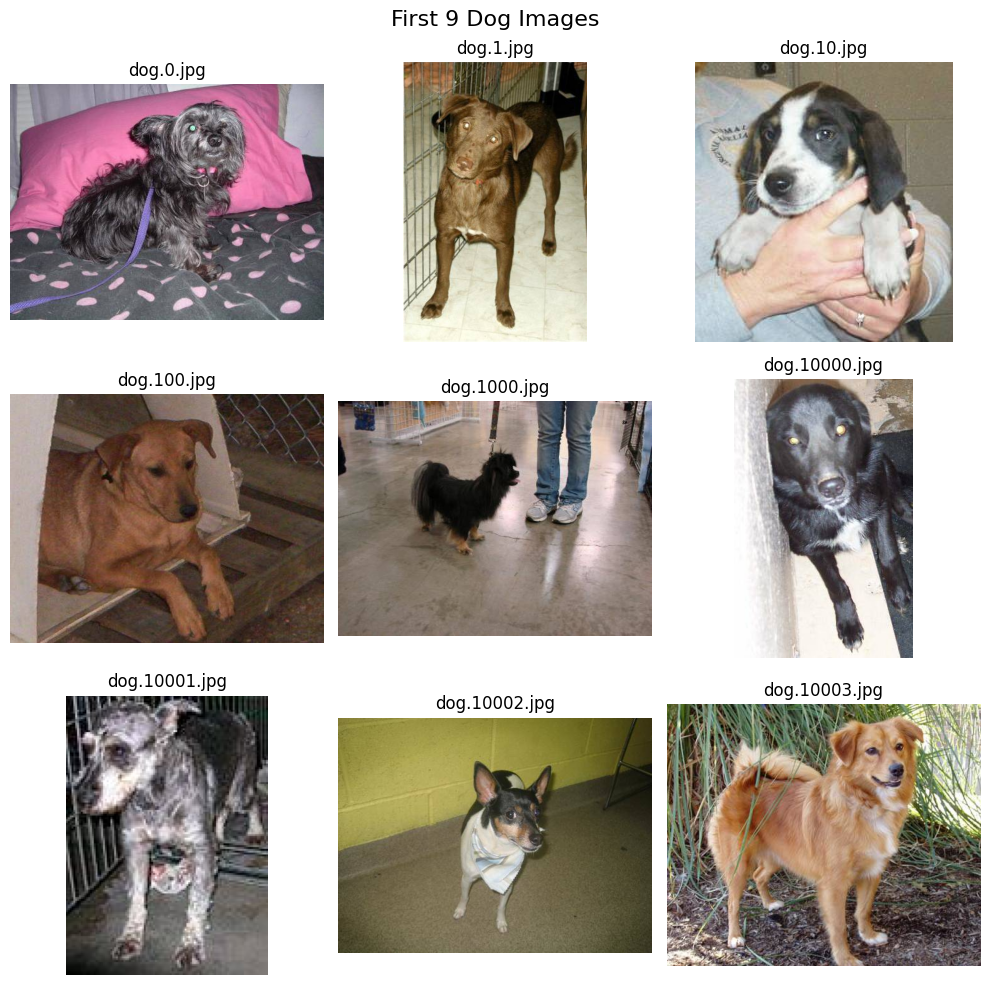

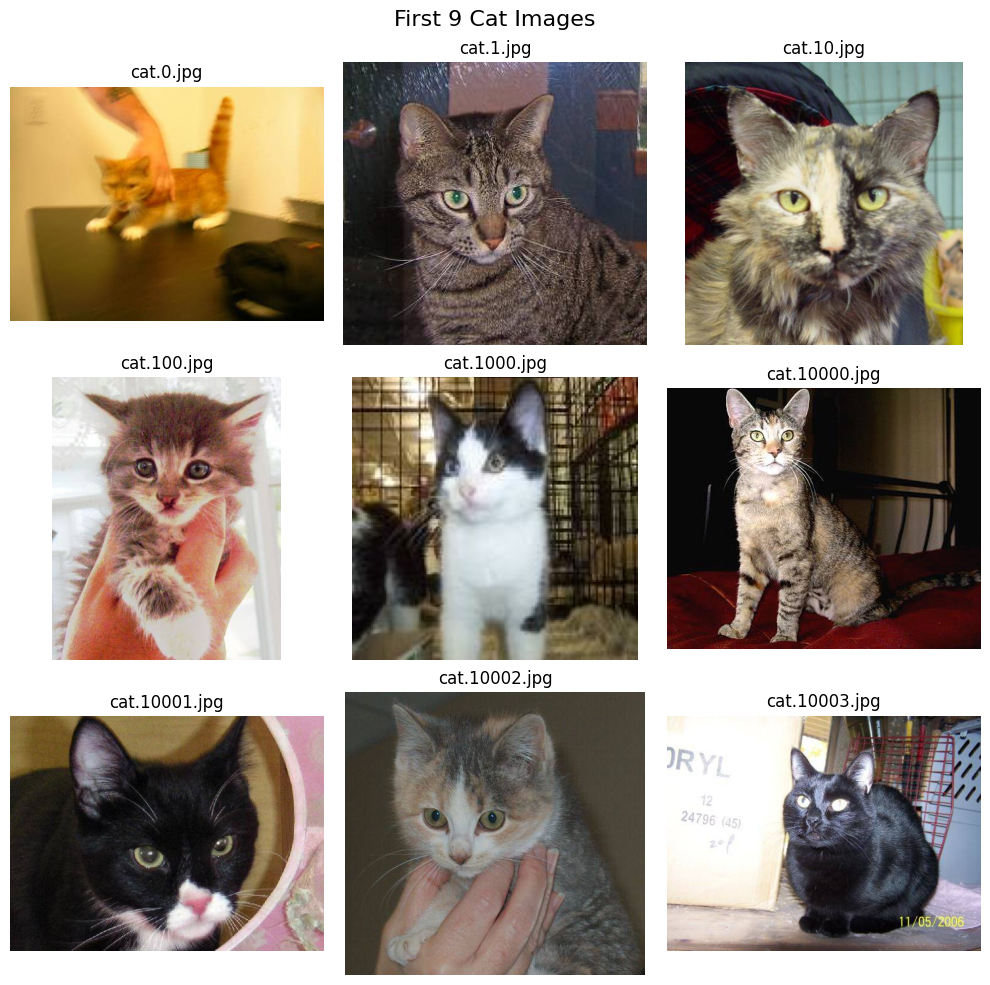

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# List first 9 dog and cat images
dog_images = sorted([f for f in os.listdir(TRAIN_DIR) if f.startswith("dog")])[:9]
cat_images = sorted([f for f in os.listdir(TRAIN_DIR) if f.startswith("cat")])[:9]


def show_images(image_filenames, title):
    plt.figure(figsize=(10, 10))
    for i, fname in enumerate(image_filenames):
        img_path = os.path.join(TRAIN_DIR, fname)
        img = mpimg.imread(img_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(fname)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Show first 9 dog images
show_images(dog_images, "First 9 Dog Images")

# Show first 9 cat images
show_images(cat_images, "First 9 Cat Images")


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Collect file paths and infer labels
filepaths = sorted([os.path.join(TRAIN_DIR, fname) for fname in os.listdir(TRAIN_DIR)])

# keep as strings instead of one-hot encoding yet because flow_from_dataframe will expect that for categorical class mode
labels = ["dog" if "dog" in fname else "cat" for fname in filepaths]

# Create DataFrame
df = pd.DataFrame({"filename": filepaths, "label": labels})

# Sample a balanced subset
df_subset, _ = train_test_split(
    df,
    train_size=DATA_SUBSET,
    stratify=df["label"],
    random_state=42,
)

# Split into train and validation sets. Stratify to ensure enough dogs and cats in each set.
train_df, valid_df = train_test_split(
    df_subset, test_size=0.2, stratify=df_subset["label"], random_state=42
)


Anytime batch size is changed to try to tweak performance & notebook run duration, should rerun these trdata an tsdata construction cells:

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

# Use flow_from_dataframe
trdata = datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

tsdata = datagen.flow_from_dataframe(
    valid_df,
    x_col="filename",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 80 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


### checking balance between cats vs. dogs in either set

In [24]:
import numpy as np

# Training data stats
print("Training batch class indices:", trdata.class_indices)
print("Training samples:", trdata.samples)
train_class_counts = np.bincount(trdata.labels)
print("Training class distribution:")
for class_label, count in zip(trdata.class_indices, train_class_counts):
    print(f"  {class_label}: {count} samples")

# Validation data stats
print("Validation samples:", tsdata.samples)
val_class_counts = np.bincount(tsdata.labels)
print("Validation class distribution:")
for class_label, count in zip(tsdata.class_indices, val_class_counts):
    print(f"  {class_label}: {count} samples")


Training batch class indices: {'cat': 0, 'dog': 1}
Training samples: 80
Training class distribution:
  cat: 40 samples
  dog: 40 samples
Validation samples: 20
Validation class distribution:
  cat: 10 samples
  dog: 10 samples


Diagnostic cell to check whether or not I shuffled something around on accident and disassociated proper labels from their images:

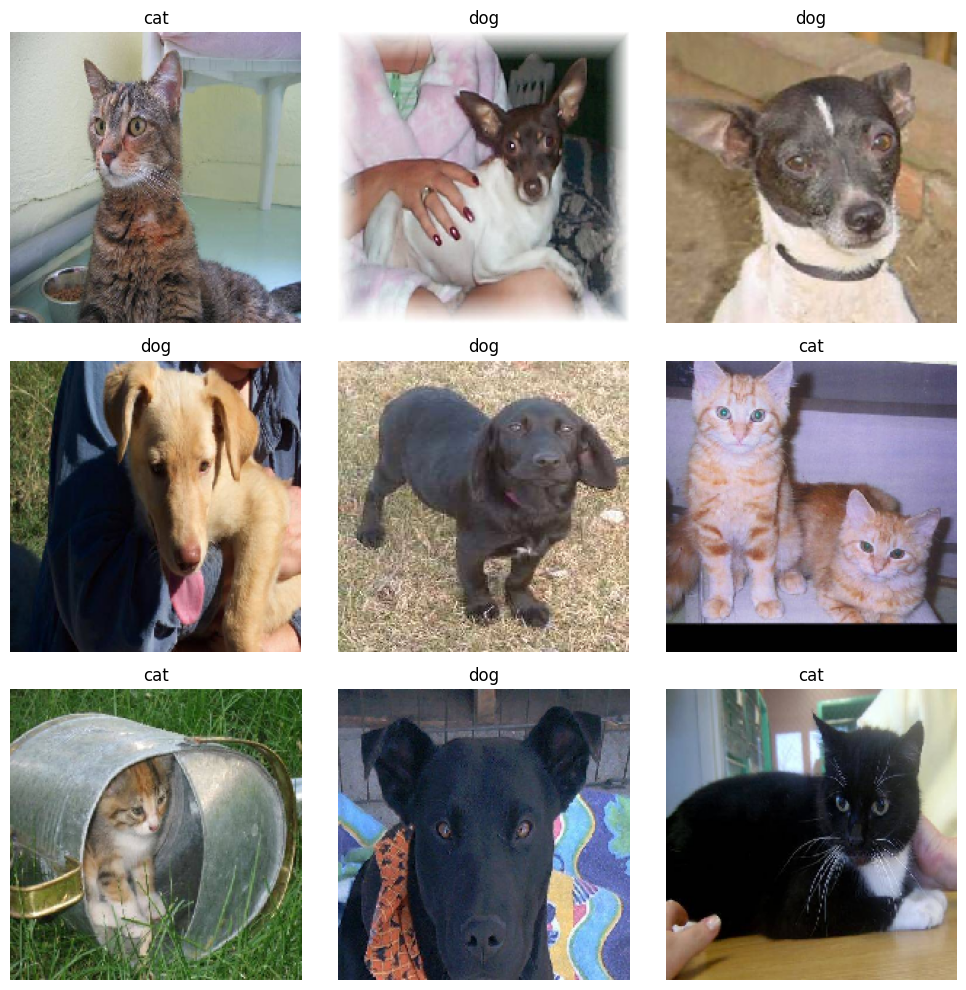

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from the training generator
images, labels = next(trdata)

# Map class indices back to labels
class_indices = {v: k for k, v in trdata.class_indices.items()}
decoded_labels = [class_indices[np.argmax(label)] for label in labels]

# Plot the first 9 images with labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(decoded_labels[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


Defining a model training function we can use for either our first simple model or one layered over VGG-16:

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" if USE_BOTH_GPUS else "0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


def train_model(
    model_builder,  # function to build the model; for multi-gpu to work, must be defined in the scope of the strategy
    train_generator,
    valid_generator,
    epochs=20,
    checkpoint_path="checkpoints/best_model.keras",
    use_multi_gpu=True,
):
    if use_multi_gpu:
        strategy = tf.distribute.MirroredStrategy()
        print(f"✅ Using {strategy.num_replicas_in_sync} GPU(s)")
        with strategy.scope():
            model = model_builder()
            model.compile(
                optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"],
            )
    else:
        print("🚫 Using single GPU or CPU only.")
        model = model_builder()
        model.compile(
            optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

    # callbacks = [
    #    ModelCheckpoint(
    #        filepath=checkpoint_path, save_best_only=True, monitor="val_accuracy"
    #    ),
    #    EarlyStopping(patience=3, restore_best_weights=True),
    # ]

    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        # callbacks=callbacks,
    )
    return model, history


In [27]:
def build_custom_model():
    return Sequential(
        [
            tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
            # Conv2D(
            #    filters=64,
            #    kernel_size=(3, 3),
            #    padding="same",
            #    activation="relu",
            # ),
            #            Conv2D(
            #                filters=64,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            #            Conv2D(
            #                filters=128,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            Conv2D(
            #                filters=128,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            #            Conv2D(
            #                filters=256,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            Conv2D(
            #                filters=256,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            Conv2D(
            #                filters=256,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            #            Conv2D(
            #                filters=512,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            Conv2D(
            #                filters=512,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            Conv2D(
            #                filters=512,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            #            Conv2D(
            #                filters=512,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            Conv2D(
            #                filters=512,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            #            Conv2D(
            #                filters=512,
            #                kernel_size=(3, 3),
            #                padding="same",
            #                activation="relu",
            #            ),
            # MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Flatten(),
            # Dense(units=4096, activation="relu"),
            # Dense(units=4096, activation="relu"),
            Dense(units=2, activation="softmax"),
        ]
    )


In [28]:
custom_model, custom_history = train_model(
    model_builder=build_custom_model,
    train_generator=trdata,
    valid_generator=tsdata,
    epochs=30,
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
✅ Using 2 GPU(s)


/mnt/c/Users/Nick/git/deep_learning_image_classification/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
INFO:tensorflow:Collective all_reduce tensors: 2 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 931ms/step - accuracy: 0.5167 - loss: 3.3139 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 635ms/step - accuracy: 0.4974 - loss: 8.1010 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 807ms/step - accuracy: 0.4844 - loss: 8.3109 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 820ms/step - accuracy: 0.5365 - loss: 7.4714 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step - accuracy: 0.4974 - loss: 8.1010 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 850ms/step - accuracy: 0.4974 - loss: 8.1010 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4844 - loss: 8.3109 - v

2025-05-29 16:41:46.208963: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 870ms/step - accuracy: 0.4844 - loss: 8.3109 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5365 - loss: 7.4714 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 717ms/step - accuracy: 0.4974 - loss: 8.1010 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step - accuracy: 0.4974 - loss: 8.1010 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 776ms/step - accuracy: 0.5365 - loss: 7.4714 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 767ms/step - accuracy: 0.4844 - loss: 8.3109 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 780ms/step - accuracy: 0.4974 - loss: 8.1010 - val_accuracy: 0.5000 - val_loss: 8.0590
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 858ms/step - accuracy: 0.5365 - loss: 7.4714 - val_accuracy: 0.5000 - val_loss: 8.0590


### Evaluating model

In [29]:
from tensorflow.keras.models import load_model

best_model = load_model("checkpoints/best_model.keras")
results = best_model.evaluate(tsdata)
print(f"Validation accuracy: {results[1]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - accuracy: 0.5000 - loss: 8.0590
Validation accuracy: 0.5000


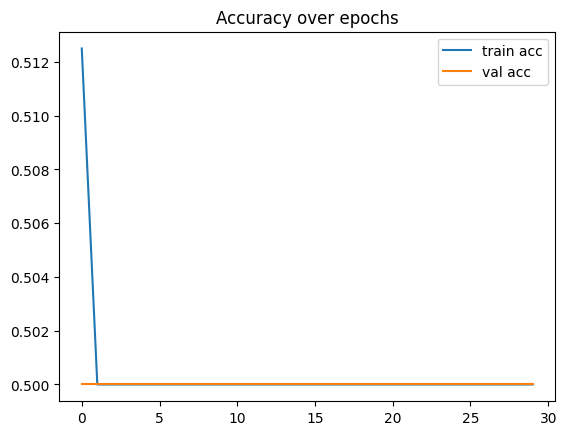

In [30]:
# visualize training history
import matplotlib.pyplot as plt

plt.plot(custom_history.history["accuracy"], label="train acc")
plt.plot(custom_history.history["val_accuracy"], label="val acc")
plt.title("Accuracy over epochs")
plt.legend()
plt.show()

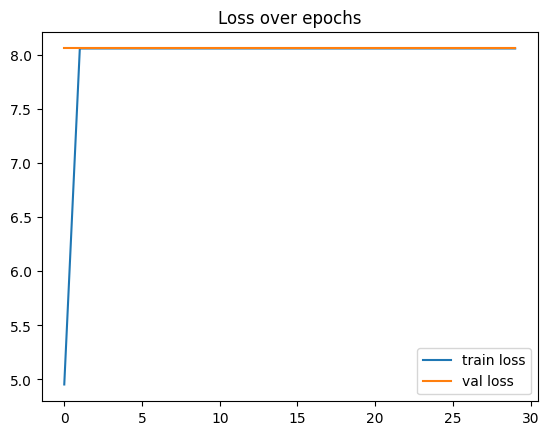

In [31]:
plt.plot(custom_history.history["loss"], label="train loss")
plt.plot(custom_history.history["val_loss"], label="val loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()